# GGS-416 Final Project - Deforestation and Degradation

In [1]:
# modules needed for processing 

import sentinelsat
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import os
import rasterio
from rasterio.mask import mask
from matplotlib import pyplot as plt
import matplotlib.patches as mpat
import numpy as np
import geopandas as gp
import zipfile
import pandas as pd

In [2]:
# credentials for api
# during problem solving found from sentinelsat quickstart: "Either way, if you get an error 401 Unauthorized, 
# your credentials were wrong or not yet active for the endpoint you are contacting" 
# credentials are working
api = SentinelAPI(
    'rwehner', 
    'Sia416fall22', 
    'https://apihub.copernicus.eu/apihub'
)

api

In [3]:
# geojson that includes Kakamega Forest in Ethiopia from geojson.io
kf_geometry = {
  "type": "Polygon",
  "coordinates": [
    [ 
      [34.85042675684193, 0.32277955006604486],
      [34.85042675684193, 0.25648957869283606],
      [34.91638107726757, 0.25648957869283606],
      [34.91638107726757, 0.32277955006604486],
      [34.85042675684193, 0.32277955006604486]
    ]
  ]
}

# convert geojson into well-known-text so that the api can be queried
kf_footprint = geojson_to_wkt(kf_geometry)
kf_footprint

'POLYGON((34.8504 0.3228,34.8504 0.2565,34.9164 0.2565,34.9164 0.3228,34.8504 0.3228))'

## Build queries and download images for time series

In [4]:
# build the query for the api
#from API reference:  Range values can be passed as two-element tuples, e.g. cloudcoverpercentage=(0, 30)
#from API reference: query(area=None, date=None, raw=None, area_relation='Intersects', order_by=None, limit=None, offset=0, **keywords)
kf22_11_metadata = api.query(
    kf_footprint,
    date=('20221101', '20221124'), # date range November 2022
    platformname='Sentinel-2',  
    processinglevel='Level-2A', # image is processed for surface reflection (not Level-1C top of atmosphere)
)

kf22_11_metadata

OrderedDict([('798c56ec-d96a-48f7-8f9b-a69f445edeae',
              {'title': 'S2A_MSIL2A_20221122T075231_N0400_R135_T36NYF_20221122T111155',
               'link': "https://apihub.copernicus.eu/apihub/odata/v1/Products('798c56ec-d96a-48f7-8f9b-a69f445edeae')/$value",
               'link_alternative': "https://apihub.copernicus.eu/apihub/odata/v1/Products('798c56ec-d96a-48f7-8f9b-a69f445edeae')/",
               'link_icon': "https://apihub.copernicus.eu/apihub/odata/v1/Products('798c56ec-d96a-48f7-8f9b-a69f445edeae')/Products('Quicklook')/$value",
               'summary': 'Date: 2022-11-22T07:52:31.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 1.11 GB',
               'ondemand': 'false',
               'generationdate': datetime.datetime(2022, 11, 22, 11, 11, 55),
               'beginposition': datetime.datetime(2022, 11, 22, 7, 52, 31, 24000),
               'endposition': datetime.datetime(2022, 11, 22, 7, 52, 31, 24000),
               'ingestiondate': datetime.datetime(2

In [5]:
# convert ordered dict into pandas dataframe then into csv for easy inspection of metadata
kf22_11_df = api.to_dataframe(kf22_11_metadata)
kf22_11_df.to_csv('kf22_11_metadata.csv')

# sorting the data frame to have the clouds with the least cloud cover at the top of the list
kf22_11_df_sorted = kf22_11_df.sort_values(
    ['cloudcoverpercentage'], ascending=[True])

kf22_11_df_sorted.to_csv('kf22_11_metadata_sorted.csv')    # printing to csv to inspect metadata

In [6]:
# create a subset of images with the least cloud 
kf22_11_df_sorted_top = kf22_11_df_sorted.head(1)
len(kf22_11_df_sorted_top)    #double checking how many images are in subset

1

In [10]:
# download images with the least cloud cover
api.download_all(kf22_11_df_sorted_top.index)

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

ResultTuple(downloaded={'798c56ec-d96a-48f7-8f9b-a69f445edeae': {'id': '798c56ec-d96a-48f7-8f9b-a69f445edeae', 'title': 'S2A_MSIL2A_20221122T075231_N0400_R135_T36NYF_20221122T111155', 'size': 1187954784, 'md5': '4a87b871bcaf6f8df90acda8d375ba12', 'date': datetime.datetime(2022, 11, 22, 7, 52, 31, 24000), 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))', 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('798c56ec-d96a-48f7-8f9b-a69f445edeae')/$value", 'Online': True, 'Creation Date': datetime.datetime(2022, 11, 22, 13, 1, 4, 934000), 'Ingestion Date': datetime.datetime(2022, 11, 22, 13, 0, 55, 101000), 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('798c56ec-d96a-48f7-8f9b-a69f445edeae')/Products('Quicklook')/$value", 'path': 'S2A_MSIL2A_20221122T075231_N0400_R135_T36NYF_20221122T111155.zip', 'd

In [24]:
# file management of downloaded zips
# find the downloaded file names, create a list, and add the only the zip files using a loop
all_filenames_in_folder = os.listdir()
kf_filenames_to_unzip = []
for filename in all_filenames_in_folder:
    if filename.endswith('.zip'): 
        kf_filenames_to_unzip.append(filename)
        
# Create a folder for the images and add the unzipped files, remove the zip for a clean workspace
kf_folder = 'kakamega_unzipped'
if not os.path.exists(kf_folder):
    os.mkdir(kf_folder)    #create the folder
for filename in kf_filenames_to_unzip:
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(kf_folder)
    os.remove(filename)

In [7]:
# rebuild query for each of the date ranges of timeseries
# June 2019, 2020, 2021, and 2022 

kf22_06_metadata = api.query(
    kf_footprint,
    date=('20220601', '20220630'), # date range June 2022
    platformname='Sentinel-2',  
    processinglevel='Level-2A', # image is processed for surface reflection (not Level-1C top of atmosphere)
)

print(kf22_06_metadata)

# convert ordered dict into pandas dataframe then into csv for easy inspection of metadata
kf22_06_df = api.to_dataframe(kf22_06_metadata)
kf22_06_df.to_csv('kf22_06_metadata.csv')

# sorting the dataframe to have least cloud cover at the top of the list
kf22_06_df_sorted = kf22_06_df.sort_values(
    ['cloudcoverpercentage'], ascending=[True])

kf22_06_df_sorted.to_csv('kf22_06_metadata_sorted.csv')    # printing to csv to inspect metadata

# create a subset of images with the least cloud 
kf22_06_df_sorted_top = kf22_06_df_sorted.head(1)

OrderedDict([('e5a013c0-7286-4280-9f35-e4f35155f98d', {'title': 'S2A_MSIL2A_20220625T074621_N0400_R135_T36NYF_20220625T112517', 'link': "https://apihub.copernicus.eu/apihub/odata/v1/Products('e5a013c0-7286-4280-9f35-e4f35155f98d')/$value", 'link_alternative': "https://apihub.copernicus.eu/apihub/odata/v1/Products('e5a013c0-7286-4280-9f35-e4f35155f98d')/", 'link_icon': "https://apihub.copernicus.eu/apihub/odata/v1/Products('e5a013c0-7286-4280-9f35-e4f35155f98d')/Products('Quicklook')/$value", 'summary': 'Date: 2022-06-25T07:46:21.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 1.03 GB', 'ondemand': 'false', 'generationdate': datetime.datetime(2022, 6, 25, 11, 25, 17), 'beginposition': datetime.datetime(2022, 6, 25, 7, 46, 21, 24000), 'endposition': datetime.datetime(2022, 6, 25, 7, 46, 21, 24000), 'ingestiondate': datetime.datetime(2022, 6, 25, 13, 1, 33, 315000), 'orbitnumber': 36597, 'relativeorbitnumber': 135, 'illuminationazimuthangle': 42.33762056484, 'illuminationzenithangle':

In [14]:
# download second image in order to select the same tile number of T36NYF
api.download(kf22_06_df_sorted.index[1])

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

{'id': '8c75e595-cb42-41db-8af5-5e2a1100bb0e',
 'title': 'S2A_MSIL2A_20220615T074621_N0400_R135_T36NYF_20220615T113017',
 'size': 1192448545,
 'md5': 'e3bbbe32708684745698214b25cc8bc5',
 'date': datetime.datetime(2022, 6, 15, 7, 46, 21, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8c75e595-cb42-41db-8af5-5e2a1100bb0e')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 6, 15, 13, 22, 22, 492000),
 'Ingestion Date': datetime.datetime(2022, 6, 15, 13, 20, 59, 142000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8c75e595-cb42-41db-8af5-5e2a1100bb0e')/Products('Quicklook')/$value",
 'path': 'S2A_MSIL2A_20220615T074621_N0400_R135_T36NYF_20220615T113017.zip',
 'downloaded_bytes': 1192448545}

In [8]:
# rebuild query for each of the date ranges of timeseries
# June 2019, 2020, 2021, and 2022 

kf21_06_metadata = api.query(
    kf_footprint,
    date=('20210601', '20210630'), # date range June 2021
    platformname='Sentinel-2',  
    processinglevel='Level-2A', # image is processed for surface reflection (not Level-1C top of atmosphere)
)

# convert ordered dict into pandas dataframe then into csv for easy inspection of metadata
kf21_06_df = api.to_dataframe(kf21_06_metadata)
kf21_06_df.to_csv('kf21_06_metadata.csv')

# sorting the dataframe to have least cloud cover at the top of the list
kf21_06_df_sorted = kf21_06_df.sort_values(
    ['cloudcoverpercentage'], ascending=[True])

kf21_06_df_sorted.to_csv('kf21_06_metadata_sorted.csv')    # printing to csv to inspect metadata

# create a subset of images with the least cloud 
kf21_06_df_sorted_top = kf21_06_df_sorted.head(1)

In [11]:
# rebuild query for each of the date ranges of timeseries
# June and November each from 2019, 2020, 2021, and 2022 

kf20_06_metadata = api.query(
    kf_footprint,
    date=('20200601', '20200630'), # date range June 2020
    platformname='Sentinel-2',  
    processinglevel='Level-2A', # image is processed for surface reflection (not Level-1C top of atmosphere)
)

# convert ordered dict into pandas dataframe then into csv for easy inspection of metadata
kf20_06_df = api.to_dataframe(kf20_06_metadata)
kf20_06_df.to_csv('kf20_06_metadata.csv')

# sorting the dataframe to have least cloud cover at the top of the list
kf20_06_df_sorted = kf20_06_df.sort_values(
    ['cloudcoverpercentage'], ascending=[True])

kf20_06_df_sorted.to_csv('kf20_06_metadata_sorted.csv')    # printing to csv to inspect metadata

# create a subset of images with the least cloud 
kf20_06_df_sorted_top = kf20_06_df_sorted.head(1)

In [12]:
# rebuild query for each of the date ranges of timeseries
# June and November each from 2019, 2020, 2021, and 2022 

kf19_06_metadata = api.query(
    kf_footprint,
    date=('20190601', '20190630'), # date range June 2019
    platformname='Sentinel-2',  
    processinglevel='Level-2A', # image is processed for surface reflection (not Level-1C top of atmosphere)
)

# convert ordered dict into pandas dataframe then into csv for easy inspection of metadata
kf19_06_df = api.to_dataframe(kf19_06_metadata)
kf19_06_df.to_csv('kf19_06_metadata.csv')

# sorting the dataframe to have least cloud cover at the top of the list
kf19_06_df_sorted = kf19_06_df.sort_values(
    ['cloudcoverpercentage'], ascending=[True])

kf19_06_df_sorted.to_csv('kf19_06_metadata_sorted.csv')    # printing to csv to inspect metadata

# create a subset of images with the least cloud 
kf19_06_df_sorted_top = kf19_06_df_sorted.head(1)

In [31]:
# June time series
# ideally all time series images would be from the same day with the same tile number with 0 cloud cover
# look at the dataframes to determine what images are closest together with the least cloud cover with the same tile# T36NYF
# best fit: 06/06/19 29% fourth image, 06/25/20 7% second image, 06/05/21 2% fourth image, 06/05/22 4% third image
print(kf19_06_df_sorted[['title','cloudcoverpercentage']])
print(kf20_06_df_sorted[['title','cloudcoverpercentage']])
print(kf21_06_df_sorted[['title','cloudcoverpercentage']])
print(kf22_06_df_sorted[['title','cloudcoverpercentage']])

                                                                                  title  \
c0441443-018b-4fe0-a0c0-6d2c21edaaa5  S2B_MSIL2A_20190606T074619_N0212_R135_T36NXF_2...   
2d0e902f-0ae3-406e-b538-e4ec92601073  S2A_MSIL2A_20190621T074621_N0212_R135_T36NXF_2...   
02534bcc-bafa-4812-8fb2-d4e6d349ff22  S2B_MSIL2A_20190616T074619_N0212_R135_T36NXF_2...   
9bfc6ac4-d266-4519-a055-080a964e4f4e  S2B_MSIL2A_20190606T074619_N0212_R135_T36NYF_2...   
7b622a1e-4ead-459c-ab88-ed0f6e7b7d23  S2A_MSIL2A_20190621T074621_N0212_R135_T36NYF_2...   
ed988ebf-fed9-45cc-bc68-519091657af7  S2B_MSIL2A_20190616T074619_N0212_R135_T36NYF_2...   
34f86b88-32f6-4bcd-8dc5-362f8882d236  S2B_MSIL2A_20190626T074619_N0212_R135_T36NYF_2...   
f6323b1d-ea83-4657-93ba-0412b539e50a  S2A_MSIL2A_20190601T074611_N0212_R135_T36NXF_2...   
fc860b1e-4840-41f7-97e7-b0f1afd36ab7  S2A_MSIL2A_20190601T074611_N0212_R135_T36NYF_2...   
91329b96-da3a-40bc-aa4e-ad495377c77f  S2B_MSIL2A_20190626T074619_N0212_R135_T36NXF_2...   

In [15]:
# start by downloading the highest cloud covers of 29%, then visually inspect that AoI is usable before bulk download
api.download(kf19_06_df_sorted.index[3])

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

{'id': '9bfc6ac4-d266-4519-a055-080a964e4f4e',
 'title': 'S2B_MSIL2A_20190606T074619_N0212_R135_T36NYF_20190606T110842',
 'size': 1194780654,
 'md5': '3bd6b763fc6166a47287e3f572cb2f5d',
 'date': datetime.datetime(2019, 6, 6, 7, 46, 19, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('9bfc6ac4-d266-4519-a055-080a964e4f4e')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2019, 6, 6, 18, 19, 48, 279000),
 'Ingestion Date': datetime.datetime(2019, 6, 6, 18, 19, 22, 722000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('9bfc6ac4-d266-4519-a055-080a964e4f4e')/Products('Quicklook')/$value",
 'path': 'S2B_MSIL2A_20190606T074619_N0212_R135_T36NYF_20190606T110842.zip',
 'downloaded_bytes': 1194780654}

In [14]:
# rebuild query for May 2019 as the whole month of June 2019 is unusable

kf19_05_metadata = api.query(
    kf_footprint,
    date=('20190501', '20190530'), # date range May 2019
    platformname='Sentinel-2',  
    processinglevel='Level-2A', # image is processed for surface reflection (not Level-1C top of atmosphere)
)

# convert ordered dict into pandas dataframe then into csv for easy inspection of metadata
kf19_05_df = api.to_dataframe(kf19_05_metadata)
kf19_05_df.to_csv('kf19_05_metadata.csv')

# sorting the dataframe to have least cloud cover at the top of the list
kf19_05_df_sorted = kf19_05_df.sort_values(
    ['cloudcoverpercentage'], ascending=[True])

kf19_05_df_sorted.to_csv('kf19_05_metadata_sorted.csv')    # printing to csv to inspect metadata

# create a subset of images with the least cloud 
kf19_05_df_sorted_top = kf19_05_df_sorted.head(1)

In [29]:
# download fifth image--5/27/19 with 10% cloud cover to visually inspect AoI to replace unusable 6/05/19
api.download(kf19_05_df_sorted.index[4])

MD5 checksumming:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

{'id': 'f7a077ed-b45e-4b6e-a2fa-06221e4cbff5',
 'title': 'S2B_MSIL2A_20190527T074619_N0212_R135_T36NYF_20190527T110844',
 'size': 1197109434,
 'md5': '5e1d9813f5e80e745987d8980bd6a71b',
 'date': datetime.datetime(2019, 5, 27, 7, 46, 19, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('f7a077ed-b45e-4b6e-a2fa-06221e4cbff5')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2019, 5, 27, 17, 52, 9, 518000),
 'Ingestion Date': datetime.datetime(2019, 5, 27, 17, 51, 37, 323000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('f7a077ed-b45e-4b6e-a2fa-06221e4cbff5')/Products('Quicklook')/$value",
 'path': 'S2B_MSIL2A_20190527T074619_N0212_R135_T36NYF_20190527T110844.zip',
 'downloaded_bytes': 1197109434}

In [31]:
# download 6/05/22 4% cloud cover, third image in df
api.download(kf22_06_df_sorted.index[2])

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

{'id': '8084fe17-bc23-4bd3-a7f2-138b8b0aa688',
 'title': 'S2A_MSIL2A_20220605T074621_N0400_R135_T36NYF_20220605T112419',
 'size': 1189402471,
 'md5': 'c800b6558c366e5edd8f85a920b60b4c',
 'date': datetime.datetime(2022, 6, 5, 7, 46, 21, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8084fe17-bc23-4bd3-a7f2-138b8b0aa688')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 6, 5, 13, 51, 12, 689000),
 'Ingestion Date': datetime.datetime(2022, 6, 5, 13, 49, 30, 501000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8084fe17-bc23-4bd3-a7f2-138b8b0aa688')/Products('Quicklook')/$value",
 'path': 'S2A_MSIL2A_20220605T074621_N0400_R135_T36NYF_20220605T112419.zip',
 'downloaded_bytes': 1189402471}

In [35]:
# download 6/05/21 2% cloud cover, fourth image in df
api.download(kf21_06_df_sorted.index[3])

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

{'id': '8d574640-5528-4a04-b76b-990635aec0be',
 'title': 'S2B_MSIL2A_20210605T074609_N0300_R135_T36NYF_20210605T103739',
 'size': 1188432765,
 'md5': '98dce4cc764b09b730f45ed0f8c81d22',
 'date': datetime.datetime(2021, 6, 5, 7, 46, 9, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8d574640-5528-4a04-b76b-990635aec0be')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2021, 6, 5, 13, 38, 11, 954000),
 'Ingestion Date': datetime.datetime(2021, 6, 5, 13, 37, 38, 216000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('8d574640-5528-4a04-b76b-990635aec0be')/Products('Quicklook')/$value",
 'path': 'S2B_MSIL2A_20210605T074609_N0300_R135_T36NYF_20210605T103739.zip',
 'downloaded_bytes': 1188432765}

In [31]:
# 06/25/20 7%, second image in df
api.download(kf20_06_df_sorted.index[1])

MD5 checksumming:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

{'id': '21e3d241-a8e7-4c62-b3d7-c00a18c1675a',
 'title': 'S2A_MSIL2A_20200625T074621_N0214_R135_T36NYF_20200625T103338',
 'size': 1182444366,
 'md5': '80cc06a2dff11ba1fbcc22f074404970',
 'date': datetime.datetime(2020, 6, 25, 7, 46, 21, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('21e3d241-a8e7-4c62-b3d7-c00a18c1675a')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2020, 6, 25, 15, 6, 8, 458000),
 'Ingestion Date': datetime.datetime(2020, 6, 25, 15, 5, 51, 482000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('21e3d241-a8e7-4c62-b3d7-c00a18c1675a')/Products('Quicklook')/$value",
 'path': 'S2A_MSIL2A_20200625T074621_N0214_R135_T36NYF_20200625T103338.zip',
 'downloaded_bytes': 1182444366}

In [37]:
# 05/17/19 1%, second image in df
api.download(kf19_05_df_sorted.index[1])

MD5 checksumming:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

{'id': 'b6df3288-487d-4f96-b1fd-a146063d40f2',
 'title': 'S2B_MSIL2A_20190517T074619_N0212_R135_T36NYF_20190517T110812',
 'size': 1184622674,
 'md5': '70d3dac5a8c7e6f7d593ee3ec4e7b2a9',
 'date': datetime.datetime(2019, 5, 17, 7, 46, 19, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('b6df3288-487d-4f96-b1fd-a146063d40f2')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2019, 5, 17, 20, 3, 21, 851000),
 'Ingestion Date': datetime.datetime(2019, 5, 17, 20, 2, 46, 918000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('b6df3288-487d-4f96-b1fd-a146063d40f2')/Products('Quicklook')/$value",
 'path': 'S2B_MSIL2A_20190517T074619_N0212_R135_T36NYF_20190517T110812.zip',
 'downloaded_bytes': 1184622674}

In [137]:
# rebuild query for May 2022 as the 6/15/22 image had atmospheric interference skewing data, no other usuable images in June

kf22_05_metadata = api.query(
    kf_footprint,
    date=('20220501', '20220530'), # date range May 2022
    platformname='Sentinel-2',  
    processinglevel='Level-2A', # image is processed for surface reflection (not Level-1C top of atmosphere)
)

# convert ordered dict into pandas dataframe then into csv for easy inspection of metadata
kf22_05_df = api.to_dataframe(kf22_05_metadata)
kf22_05_df.to_csv('kf22_05_metadata.csv')

# sorting the dataframe to have least cloud cover at the top of the list
kf22_05_df_sorted = kf22_05_df.sort_values(
    ['cloudcoverpercentage'], ascending=[True])

kf22_05_df_sorted.to_csv('kf22_05_metadata_sorted.csv')    # printing to csv to inspect metadata

# create a subset of images with the least cloud 
kf22_05_df_sorted_top = kf22_05_df_sorted.head(1)

In [142]:
# 5/16/22 <1%, first image in df
api.download(kf22_05_df_sorted.index[0])

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

{'id': '89989fed-78c8-46da-a97d-3c262270e35a',
 'title': 'S2A_MSIL2A_20220516T074621_N0400_R135_T36NYF_20220516T124012',
 'size': 1189022223,
 'md5': 'f39e8c93f2bfe7524f468bd80e837072',
 'date': datetime.datetime(2022, 5, 16, 7, 46, 21, 24000),
 'footprint': 'POLYGON((34.79691598168977 0.904463645229748,35.78297722553378 0.903837296874274,35.782636294845624 -0.08837769347984,34.7966956471426 -0.088438933321785,34.79691598168977 0.904463645229748))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('89989fed-78c8-46da-a97d-3c262270e35a')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 5, 16, 14, 57, 2, 883000),
 'Ingestion Date': datetime.datetime(2022, 5, 16, 14, 56, 15, 388000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('89989fed-78c8-46da-a97d-3c262270e35a')/Products('Quicklook')/$value",
 'path': 'S2A_MSIL2A_20220516T074621_N0400_R135_T36NYF_20220516T124012.zip',
 'downloaded_bytes': 1189022223}

## Clip images to AoI, read images and bands

In [127]:
# after visually inspecting where cloud cover was in relation to the AoI, needed to change time series dates to:
# time_series_a: 5/17/19, 6/25/20, 6/5/21, 5/16/22
# time_series_b: 11/17/21, 10/23/22...not enough usable images

# define boundary for clipping AoI a section of Kakamega Forest converting to UTM with epsg.io
kf_aoi_geometry = [{
  "type": "Polygon",
  "coordinates": [
    [ 
      [705938.9657709773, 35695.58166733245],
      [705940.1630230347, 28364.69776423637],
      [713283.1483790588, 28365.77869749741],
      [713281.9083744495, 35696.94195823307],
      [705938.9657709773, 35695.58166733245]
    ]
  ]
}]
kf_aoi_geometry    #test

[{'type': 'Polygon',
  'coordinates': [[[705938.9657709773, 35695.58166733245],
    [705940.1630230347, 28364.69776423637],
    [713283.1483790588, 28365.77869749741],
    [713281.9083744495, 35696.94195823307],
    [705938.9657709773, 35695.58166733245]]]}]

In [128]:
# for loop to automate image processing
# first step is to make sure all band images for one date are in the same folder as the notebook file 
# removing images into processed folder when done and begin again with next date
# filename_w,x,y,z for 5/17/19, 6/25/20, 6/5/21, 5/16/22 respectively 
# bring in Bands 3 green, 4 red, 5 rededge, 6 rededge, 8 NIR, 8a NIR, 11 SWIR and 1,2,3,4,5,6,7 respectively

#counter for "for-loop"
counter = 1

for f in os.listdir("."):
    if f.endswith(".jp2"):
        
        # "f" is the jp2 file in this for loop, it is processed in a typical manner for the clip
        # assignment of f to variable, as well as opening the jp2 file as a rasterio object 
        image_file = f
        my_raster_image = rasterio.open(f)
        
        # opening the image as rasterio object again for facilitaition of clipping
        with rasterio.open(image_file) as img:
            clipped, transform = mask(img, kf_aoi_geometry, crop=True)
        
        # copying meta from orginal image
        meta = my_raster_image.meta.copy()    
        
        # updating metadata with new data from the clipped image
        meta.update(    
        {
    
        "transform": transform,
        "height":clipped.shape[1],
        "width":clipped.shape[2]
        }
        )
        
        # writing the clipped image to a tif file and using the counter to ensure that the file is not overwritten 
        # change letter 'kf_(X)' depending on position in time series     
        with rasterio.open('kf_w'+str(counter)+'.tif', 'w', **meta) as my_writer_object:
            my_writer_object.write(clipped)
            print('Writing complete')
            
        counter = counter + 1   
        my_raster_image.close()

        # loop should print writing complete for however many bands are processed, ie:7 band images = "Writing complete" * 7
        # rerun code with next batch of .jp2 images for a total of 4 times 

Writing complete
Writing complete


In [4]:
# assign files as rasterio objects
# Working with the bands dates 5/17/19--w, 6/25/20--x, 6/5/21, 10/11/21--y, 6/15/22--z 
# B03--1, B04--2, B05--3, B06a--4, B08--5, B08a--6, B11--7 

w1 = "kf_w1.tif"  #green
w1_ro = rasterio.open(w1)
w2 = "kf_w2.tif"  #red
w2_ro = rasterio.open(w2)
w3 = "kf_w3.tif"  #red edge
w3_ro= rasterio.open(w3)
w4 = "kf_w4.tif"  #red edge
w4_ro = rasterio.open(w4)
w5 = "kf_w5.tif"  #nir
w5_ro = rasterio.open(w5)
w6 = "kf_w6.tif"  #nir-a
w6_ro= rasterio.open(w6)
w7 = "kf_w7.tif"  #swir
w7_ro = rasterio.open(w7)

x1 = "kf_x1.tif"
x1_ro = rasterio.open(x1)
x2 = "kf_x2.tif"
x2_ro = rasterio.open(x2)
x3 = "kf_x3.tif"
x3_ro= rasterio.open(x3)
x4 = "kf_x4.tif"
x4_ro = rasterio.open(x4)
x5 = "kf_x5.tif"
x5_ro = rasterio.open(x5)
x6 = "kf_x6.tif"
x6_ro= rasterio.open(x6)
x7 = "kf_x7.tif"
x7_ro = rasterio.open(x7)

y1 = "kf_y1.tif"
y1_ro = rasterio.open(y1)
y2 = "kf_y2.tif"
y2_ro = rasterio.open(y2)
y3 = "kf_y3.tif"
y3_ro= rasterio.open(y3)
y4 = "kf_y4.tif"
y4_ro = rasterio.open(y4)
y5 = "kf_y5.tif"
y5_ro = rasterio.open(y5)
y6 = "kf_y6.tif"
y6_ro= rasterio.open(y6)
y7 = "kf_y7.tif"
y7_ro = rasterio.open(y7)

z1 = "kf_z1.tif"
z1_ro = rasterio.open(z1)
z2 = "kf_z2.tif"
z2_ro = rasterio.open(z2)
z3 = "kf_z3.tif"
z3_ro= rasterio.open(z3)
z4 = "kf_z4.tif"
z4_ro = rasterio.open(z4)
z5 = "kf_z5.tif"
z5_ro = rasterio.open(z5)
z6 = "kf_z6.tif"
z6_ro= rasterio.open(z6)
z7 = "kf_z7.tif"
z7_ro = rasterio.open(z7)


In [5]:
# add new date 5/16/22 to compare against 6/15/22 to double check the data as 6/15/22 as it appears off from others
zz1 = "kf_zz1.tif"
zz1_ro = rasterio.open(zz1)
zz2 = "kf_zz2.tif"
zz2_ro = rasterio.open(zz2)
zz3 = "kf_zz3.tif"
zz3_ro= rasterio.open(zz3)
zz4 = "kf_zz4.tif"
zz4_ro = rasterio.open(zz4)
zz5 = "kf_zz5.tif"
zz5_ro = rasterio.open(zz5)
zz6 = "kf_zz6.tif"
zz6_ro= rasterio.open(zz6)
zz7 = "kf_zz7.tif"
zz7_ro = rasterio.open(zz7)

In [6]:
# read the bands 
# Working with the bands dates 5/17/19--w, 6/25/20--x, 6/5/21--y, 6/15/22--z
# B03 green--1, B04 red--2, B05 red edge--3, B06 red edge--4, B08 NIR--5, B08a NIR--6, B11 SWIR--7 

B03_w = w1_ro.read(1)
B03_x = x1_ro.read(1)
B03_y = y1_ro.read(1)
B03_z = z1_ro.read(1)
B03_zz = zz1_ro.read(1)

B04_w = w2_ro.read(1)
B04_x = x2_ro.read(1)
B04_y = y2_ro.read(1)
B04_z = z2_ro.read(1)
B04_zz = zz2_ro.read(1)

B05_w = w3_ro.read(1)
B05_x = x3_ro.read(1)
B05_y = y3_ro.read(1)
B05_z = z3_ro.read(1)
B05_zz = zz3_ro.read(1)

B06_w = w4_ro.read(1)
B06_x = x4_ro.read(1)
B06_y = y4_ro.read(1)
B06_z = z4_ro.read(1)
B06_zz = zz4_ro.read(1)

B08_w = w5_ro.read(1)
B08_x = x5_ro.read(1)
B08_y = y5_ro.read(1)
B08_z = z5_ro.read(1)
B08_zz = zz5_ro.read(1)

B08a_w = w6_ro.read(1)
B08a_x = x6_ro.read(1)
B08a_y = y6_ro.read(1)
B08a_z = z6_ro.read(1)
B08a_zz = zz6_ro.read(1)

B11_w = w7_ro.read(1)
B11_x = x7_ro.read(1)
B11_y = y7_ro.read(1)
B11_z = z7_ro.read(1)
B11_zz = zz7_ro.read(1)

In [7]:
# clip image to remove nan from edges from when geojson's crs was transformed
# Bands 3,4,8 are 10m resolution and bands 5,6,8a,11 are 20 resolution
print(B03_w.shape)
B03_w_clip = B03_w[5:730:, 5:730]
print(B03_w_clip.shape)
print(B08a_w.shape)
B08a_w_clip = B08a_w[3:363:, 3:363]
print(B08a_w_clip.shape)

(734, 736)
(725, 725)
(367, 369)
(360, 360)


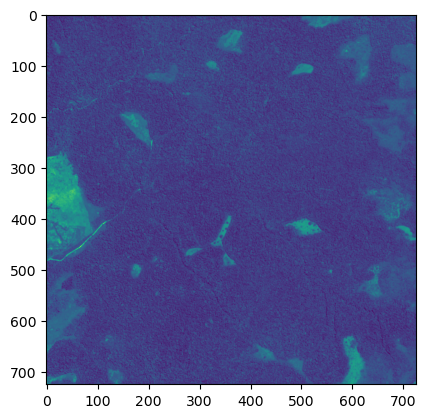

In [56]:
# visually inspect edges to ensure removal of nans
plt.imshow(B03_w_clip)

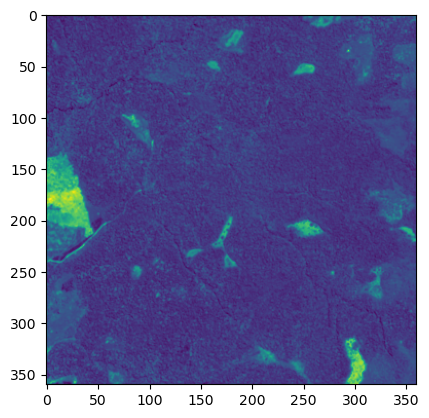

In [57]:
# visually inspect edges to ensure removal of nans
plt.imshow(B08a_w_clip)

In [8]:
# proceed to clip all bands

B03_w = B03_w[5:730:, 5:730]
B03_x = B03_x[5:730:, 5:730]
B03_y = B03_y[5:730:, 5:730]
B03_z = B03_z[5:730:, 5:730]
B03_zz = B03_zz[5:730:, 5:730]

B04_w = B04_w[5:730:, 5:730]
B04_x = B04_x[5:730:, 5:730]
B04_y = B04_y[5:730:, 5:730]
B04_z = B04_z[5:730:, 5:730]
B04_zz = B04_zz[5:730:, 5:730]

B05_w = B05_w[3:363:, 3:363]
B05_x = B05_x[3:363:, 3:363]
B05_y = B05_y[3:363:, 3:363]
B05_z = B05_z[3:363:, 3:363]
B05_zz = B05_zz[3:363:, 3:363]

B06_w = B06_w[3:363:, 3:363]
B06_x = B06_x[3:363:, 3:363]
B06_y = B06_y[3:363:, 3:363]
B06_z = B06_z[3:363:, 3:363]
B06_zz = B06_zz[3:363:, 3:363]

B08_w = B08_w[5:730:, 5:730]
B08_x = B08_x[5:730:, 5:730]
B08_y = B08_y[5:730:, 5:730]
B08_z = B08_z[5:730:, 5:730]
B08_zz = B08_zz[5:730:, 5:730]

B08a_w = B08a_w[3:363:, 3:363]
B08a_x = B08a_x[3:363:, 3:363]
B08a_y = B08a_y[3:363:, 3:363]
B08a_z = B08a_z[3:363:, 3:363]
B08a_zz = B08a_zz[3:363:, 3:363]

B11_w = B11_w[3:363:, 3:363]
B11_x = B11_x[3:363:, 3:363]
B11_y = B11_y[3:363:, 3:363]
B11_z = B11_z[3:363:, 3:363]
B11_zz = B11_zz[3:363:, 3:363]

### Vegetation Indices

In [9]:
# NDVI normalized difference vegetation index
np.seterr(divide='ignore', invalid='ignore') #ignores warning of dividing by zero

ndvi_w = (B08_w.astype(float)-B04_w.astype(float))/(B08_w.astype(float)+B04_w.astype(float))
ndvi_x = (B08_x.astype(float)-B04_x.astype(float))/(B08_x.astype(float)+B04_x.astype(float))
ndvi_y = (B08_y.astype(float)-B04_y.astype(float))/(B08_y.astype(float)+B04_y.astype(float))
ndvi_z = (B08_z.astype(float)-B04_z.astype(float))/(B08_z.astype(float)+B04_z.astype(float))
ndvi_zz = (B08_zz.astype(float)-B04_zz.astype(float))/(B08_zz.astype(float)+B04_zz.astype(float))

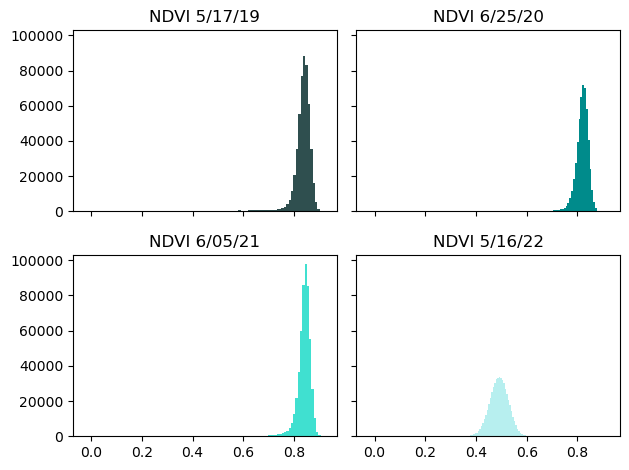

In [10]:
# NDVI normalized difference vegetation index
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, sharey=True)

# get data
ndvi1_w = ndvi_w[np.not_equal(ndvi_w, w1_ro.nodata)]
ndvi2_x = ndvi_x[np.not_equal(ndvi_x, x1_ro.nodata)]
ndvi3_y = ndvi_y[np.not_equal(ndvi_y, y1_ro.nodata)]
ndvi4_z = ndvi_z[np.not_equal(ndvi_z, z1_ro.nodata)]
ndvi4_zz = ndvi_zz[np.not_equal(ndvi_zz, z1_ro.nodata)]

# create the histogram
ax1[0].hist(ndvi1_w, bins=100, color='darkslategray')
ax1[1].hist(ndvi2_x, bins=100, color='darkcyan')
ax2[0].hist(ndvi3_y, bins=100, color='turquoise')
ax2[1].hist(ndvi4_zz, bins=100, color='paleturquoise', alpha=0.9)

# add plot titles 
ax1[0].set_title('NDVI 5/17/19')
ax1[1].set_title('NDVI 6/25/20')
ax2[0].set_title('NDVI 6/05/21')
ax2[1].set_title('NDVI 5/16/22')

# sufficient space between our plots
fig.tight_layout()
fig.savefig("kakamega_ndvi_histograms.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

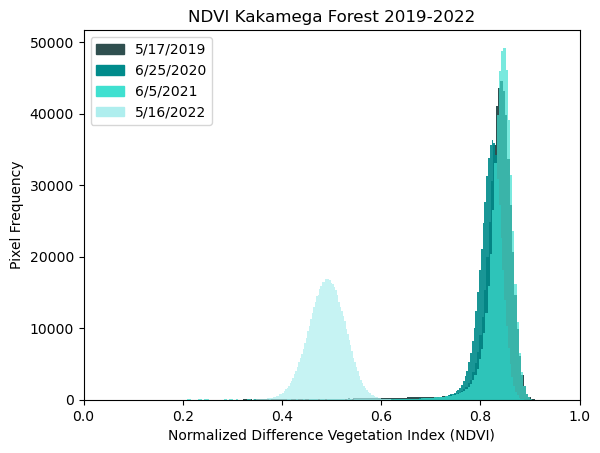

In [11]:
fig, ax = plt.subplots()  

bin_number = 200

ax.hist(ndvi1_w, color='darkslategray', bins=bin_number)
ax.hist(ndvi2_x, color='darkcyan', bins=bin_number, alpha=0.9)
ax.hist(ndvi3_y,  color='turquoise', bins=bin_number, alpha=0.7)
ax.hist(ndvi4_zz, color='paleturquoise', bins=bin_number, alpha=0.7)

ax.set_title('NDVI Kakamega Forest 2019-2022')
ax.set_xlabel('Normalized Difference Vegetation Index (NDVI)')
ax.set_ylabel('Pixel Frequency')
plt.xlim([0, 1])

handle1 = mpat.Patch(color='darkslategray', label='5/17/2019')
handle2 = mpat.Patch(color='darkcyan', label='6/25/2020')
handle3 = mpat.Patch(color='turquoise', label='6/5/2021')
handle4 = mpat.Patch(color='paleturquoise', label='5/16/2022')
ax.legend(handles=[handle1, handle2, handle3, handle4])

fig.savefig("kakamega_ndvi_hist_time_series.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

In [12]:
# NDMI normalized difference moisture index
np.seterr(divide='ignore', invalid='ignore') #ignores warning of dividing by zero

ndmi_w = (B08a_w.astype(float)-B11_w.astype(float))/(B08a_w.astype(float)+B11_w.astype(float))
ndmi_x = (B08a_x.astype(float)-B11_x.astype(float))/(B08a_x.astype(float)+B11_x.astype(float))
ndmi_y = (B08a_y.astype(float)-B11_y.astype(float))/(B08a_y.astype(float)+B11_y.astype(float))
ndmi_z = (B08a_z.astype(float)-B11_z.astype(float))/(B08a_z.astype(float)+B11_z.astype(float))
ndmi_zz = (B08a_zz.astype(float)-B11_zz.astype(float))/(B08a_zz.astype(float)+B11_zz.astype(float))

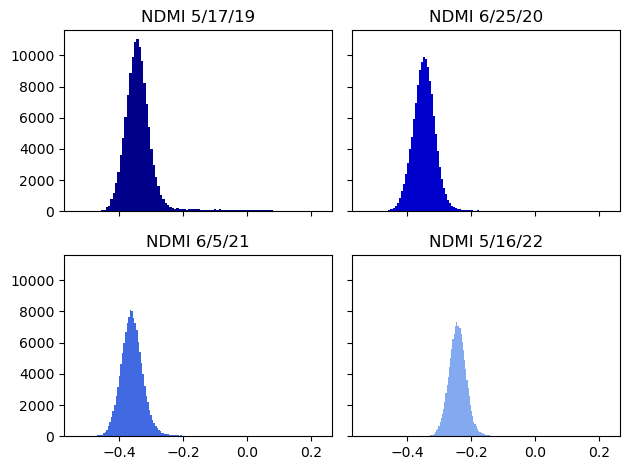

In [13]:
# NDMI normalized difference moisture index
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, sharey=True)

# get data
ndmi1_w = ndmi_w[np.not_equal(ndmi_w, w1_ro.nodata)]
ndmi2_x = ndmi_x[np.not_equal(ndmi_x, x1_ro.nodata)]
ndmi3_y = ndmi_y[np.not_equal(ndmi_y, y1_ro.nodata)]
ndmi4_z = ndmi_z[np.not_equal(ndmi_z, z1_ro.nodata)]
ndmi4_zz = ndmi_zz[np.not_equal(ndmi_zz, z1_ro.nodata)]

# create the histogram
ax1[0].hist(ndmi1_w, bins=100, color='darkblue')
ax1[1].hist(ndmi2_x, bins=100, color='mediumblue')
ax2[0].hist(ndmi3_y, bins=100, color='royalblue')
ax2[1].hist(ndmi4_zz, bins=100, color='cornflowerblue', alpha=0.8)

# add plot titles 
ax1[0].set_title('NDMI 5/17/19')
ax1[1].set_title('NDMI 6/25/20')
ax2[0].set_title('NDMI 6/5/21')
ax2[1].set_title('NDMI 5/16/22')

# sufficient space between our plots
fig.tight_layout()
fig.savefig("kakamega_ndmi_histograms.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

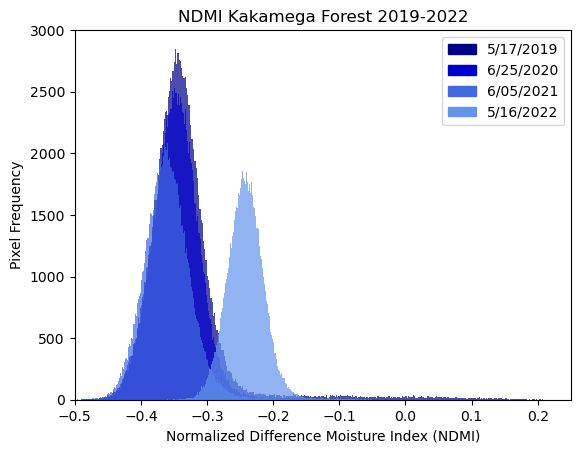

In [14]:
fig, ax = plt.subplots()  

bin_number = 400

ax.hist(ndmi1_w, color='darkblue', bins=bin_number, alpha=0.7)
ax.hist(ndmi2_x, color='mediumblue', bins=bin_number, alpha=0.7)
ax.hist(ndmi3_y,  color='royalblue', bins=bin_number, alpha=0.7)
ax.hist(ndmi4_zz, color='cornflowerblue', bins=bin_number, alpha=0.7)

ax.set_title('NDMI Kakamega Forest 2019-2022')
ax.set_xlabel('Normalized Difference Moisture Index (NDMI)')
ax.set_ylabel('Pixel Frequency')
plt.xlim([-0.5, 0.25])
plt.ylim([0,3000])

handle1 = mpat.Patch(color='darkblue', label='5/17/2019')
handle2 = mpat.Patch(color='mediumblue', label='6/25/2020')
handle3 = mpat.Patch(color='royalblue', label='6/05/2021')
handle4 = mpat.Patch(color='cornflowerblue', label='5/16/2022')
ax.legend(handles=[handle1, handle2, handle3, handle4])

fig.savefig("kakamega_ndmi_his_time_series.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

In [15]:
# RENDVI red edge normalized difference vegetation index
np.seterr(divide='ignore', invalid='ignore') #ignores warning of dividing by zero

rendvi_w = (B06_w.astype(float)-B05_w.astype(float))/(B06_w.astype(float)+B05_w.astype(float))
rendvi_x = (B06_x.astype(float)-B05_x.astype(float))/(B06_x.astype(float)+B05_x.astype(float))
rendvi_y = (B06_y.astype(float)-B05_y.astype(float))/(B06_y.astype(float)+B05_y.astype(float))
rendvi_z = (B06_z.astype(float)-B05_z.astype(float))/(B06_z.astype(float)+B05_z.astype(float))
rendvi_zz = (B06_zz.astype(float)-B05_zz.astype(float))/(B06_zz.astype(float)+B05_zz.astype(float))

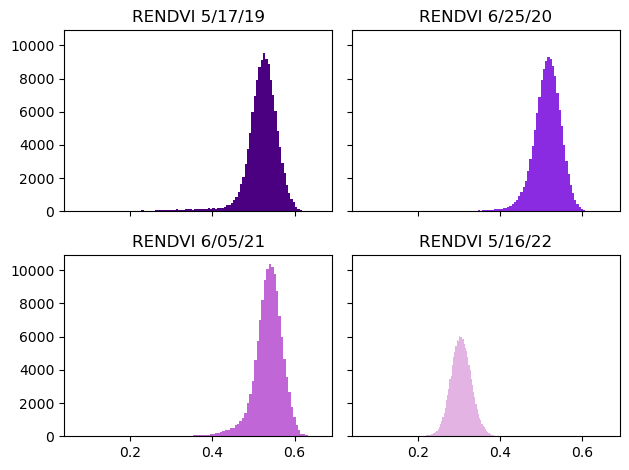

In [16]:
#
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, sharey=True)

# get data
rendvi1_w = rendvi_w[np.not_equal(rendvi_w, w1_ro.nodata)]
rendvi2_x = rendvi_x[np.not_equal(rendvi_x, x1_ro.nodata)]
rendvi3_y = rendvi_y[np.not_equal(rendvi_y, y1_ro.nodata)]
rendvi4_z = rendvi_z[np.not_equal(rendvi_z, z1_ro.nodata)]
rendvi4_zz = rendvi_zz[np.not_equal(rendvi_zz, z1_ro.nodata)]

# create the histogram
ax1[0].hist(rendvi1_w, bins=100, color='indigo')
ax1[1].hist(rendvi2_x, bins=100, color='blueviolet')
ax2[0].hist(rendvi3_y, bins=100, color='mediumorchid', alpha=0.9)
ax2[1].hist(rendvi4_zz, bins=100, color='plum', alpha=0.8)

# add plot titles 
ax1[0].set_title('RENDVI 5/17/19')
ax1[1].set_title('RENDVI 6/25/20')
ax2[0].set_title('RENDVI 6/05/21')
ax2[1].set_title('RENDVI 5/16/22')

# sufficient space between our plots
fig.tight_layout()
fig.savefig("kakamega_redvi_histograms.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

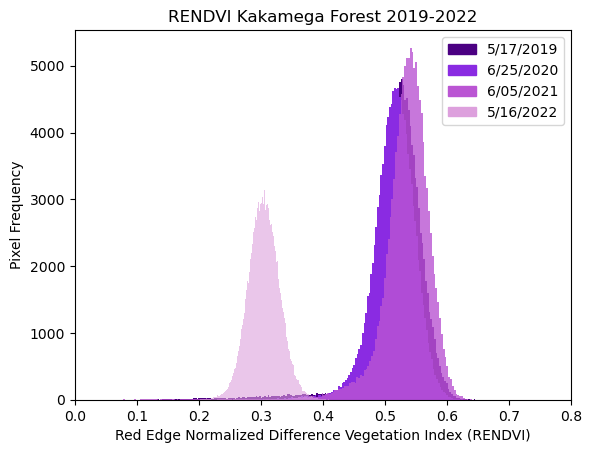

In [17]:
fig, ax = plt.subplots()  

bin_number = 200

ax.hist(rendvi1_w, color='indigo', bins=bin_number)
ax.hist(rendvi2_x, color='blueviolet', bins=bin_number)
ax.hist(rendvi3_y,  color='mediumorchid', bins=bin_number, alpha=0.8)
ax.hist(rendvi4_zz, color='plum', bins=bin_number, alpha=0.6)

ax.set_title('RENDVI Kakamega Forest 2019-2022')
ax.set_xlabel('Red Edge Normalized Difference Vegetation Index (RENDVI)')
ax.set_ylabel('Pixel Frequency')
plt.xlim([0, 0.8])

handle1 = mpat.Patch(color='indigo', label='5/17/2019')
handle2 = mpat.Patch(color='blueviolet', label='6/25/2020')
handle3 = mpat.Patch(color='mediumorchid', label='6/05/2021')
handle4 = mpat.Patch(color='plum', label='5/16/2022')
ax.legend(handles=[handle1, handle2, handle3, handle4])

fig.savefig("kakamega_rendvi_hist_time_series.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

In [18]:
gci_w = B08_w.astype(float)/B03_w.astype(float)-1
gci_x = B08_x.astype(float)/B03_x.astype(float)-1
gci_y = B08_y.astype(float)/B03_y.astype(float)-1
gci_z = B08_z.astype(float)/B03_z.astype(float)-1
gci_zz = B08_zz.astype(float)/B03_zz.astype(float)-1

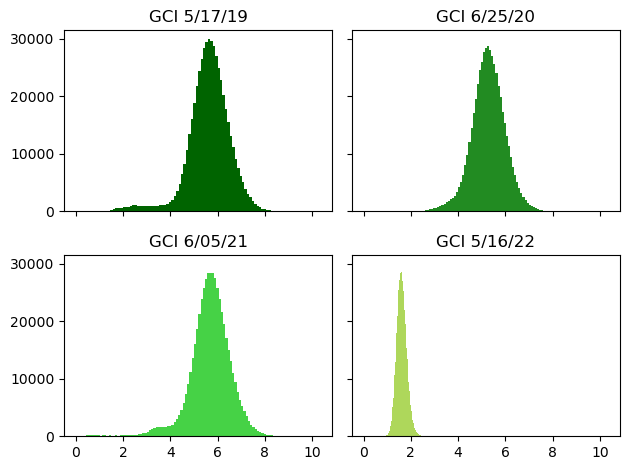

In [19]:
#
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, sharey=True)

# get data
gci1_w = gci_w[np.not_equal(gci_w, w1_ro.nodata)]
gci2_x = gci_x[np.not_equal(gci_x, x1_ro.nodata)]
gci3_y = gci_y[np.not_equal(gci_y, y1_ro.nodata)]
gci4_z = gci_z[np.not_equal(gci_z, z1_ro.nodata)]
gci4_zz = gci_zz[np.not_equal(gci_zz, z1_ro.nodata)]

# create the histogram
ax1[0].hist(gci1_w, bins=100, color='darkgreen')
ax1[1].hist(gci2_x, bins=100, color='forestgreen')
ax2[0].hist(gci3_y, bins=100, color='limegreen', alpha=0.9)
ax2[1].hist(gci4_zz, bins=100, color='yellowgreen', alpha=0.8)

# add plot titles 
ax1[0].set_title('GCI 5/17/19')
ax1[1].set_title('GCI 6/25/20')
ax2[0].set_title('GCI 6/05/21')
ax2[1].set_title('GCI 5/16/22')

# sufficient space between our plots
fig.tight_layout()
fig.savefig("kakamega_gci_histograms.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

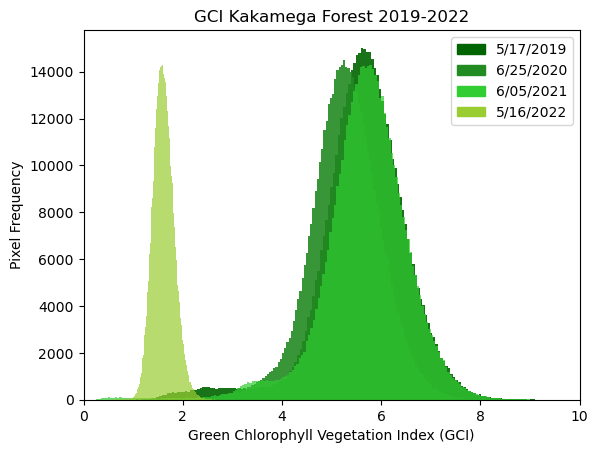

In [20]:
fig, ax = plt.subplots()  

bin_number = 200

ax.hist(gci1_w, color='darkgreen', bins=bin_number, alpha=0.9)
ax.hist(gci2_x, color='forestgreen', bins=bin_number, alpha=0.9)
ax.hist(gci3_y,  color='limegreen', bins=bin_number, alpha=0.7)
ax.hist(gci4_zz, color='yellowgreen', bins=bin_number, alpha=0.7)

ax.set_title('GCI Kakamega Forest 2019-2022')
ax.set_xlabel('Green Chlorophyll Vegetation Index (GCI)')
ax.set_ylabel('Pixel Frequency')
plt.xlim([0, 10])

handle1 = mpat.Patch(color='darkgreen', label='5/17/2019')
handle2 = mpat.Patch(color='forestgreen', label='6/25/2020')
handle3 = mpat.Patch(color='limegreen', label='6/05/2021')
handle4 = mpat.Patch(color='yellowgreen', label='5/16/2022')
ax.legend(handles=[handle1, handle2, handle3, handle4])

fig.savefig("kakamega_gci_hist_time_series.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

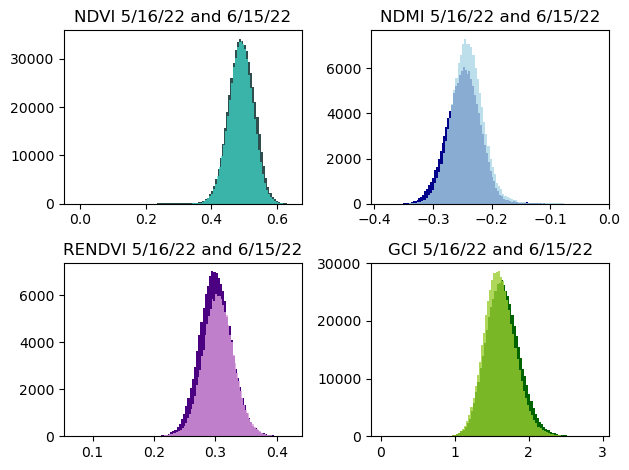

In [21]:
# There was a large difference of 5/16/22 and the other time series images
# concerned that 5/16/22 was a bad image with possible atmospheric interference skewing the data
# checked against 6/15/22 and images were largely similar
# proceed using 5/16/22

fig, (ax1, ax2) = plt.subplots(2, 2)

# create the histogram
ax1[0].hist(ndvi4_z, bins=100, color='darkslategray')
ax1[0].hist(ndvi4_zz, bins=100, color='turquoise', alpha=0.7)

ax1[1].hist(ndmi4_z, bins=100, color='darkblue')
ax1[1].hist(ndmi4_zz, bins=100, color='lightblue', alpha=0.8)

ax2[0].hist(rendvi4_z, bins=100, color='indigo')
ax2[0].hist(rendvi4_zz, bins=100, color='plum', alpha=0.8)

ax2[1].hist(gci4_z, bins=100, color='darkgreen')
ax2[1].hist(gci4_zz, bins=100, color='yellowgreen', alpha=0.8)

# add plot titles 
ax1[0].set_title('NDVI 5/16/22 and 6/15/22')
ax1[1].set_title('NDMI 5/16/22 and 6/15/22')
ax2[0].set_title('RENDVI 5/16/22 and 6/15/22')
ax2[1].set_title('GCI 5/16/22 and 6/15/22')

# sufficient space between our plots
fig.tight_layout()
fig.savefig("kakamega_comparison2022.png", dpi=300, bbox_inches='tight', pad_inches=0.7, transparent=True)

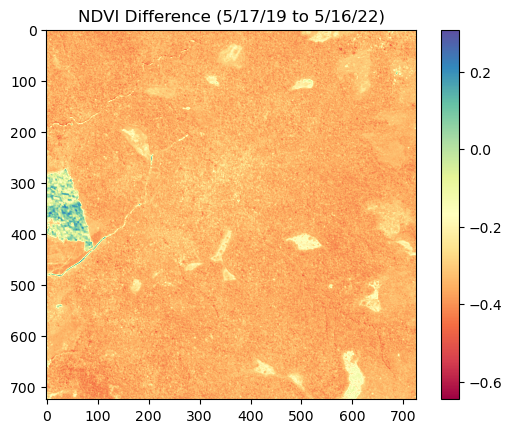

<Figure size 640x480 with 0 Axes>

In [22]:
# change detection = after - before
# blue is ndvi gain and red is ndvi loss

ndvi_diff = ndvi_zz - ndvi_w

# plt.figure(figsize=(9, 8))
plt.imshow(ndvi_diff, cmap='Spectral')
plt.title("NDVI Difference (5/17/19 to 5/16/22)")
plt.colorbar()
plt.show()

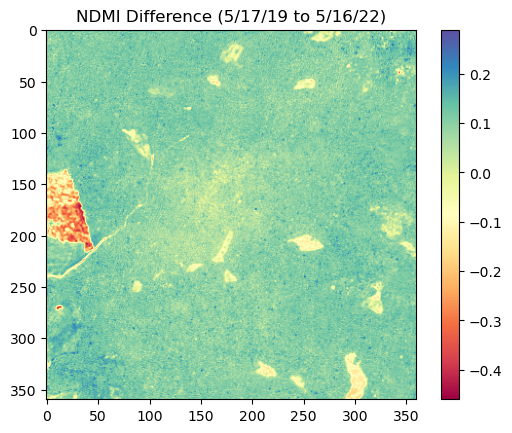

<Figure size 640x480 with 0 Axes>

In [23]:
# change detection = after - before
# blue is ndmi gain and red is ndmi loss

ndmi_diff = ndmi_zz - ndmi_w
plt.imshow(ndmi_diff, cmap='Spectral')
plt.title("NDMI Difference (5/17/19 to 5/16/22)")
plt.colorbar()
plt.show()

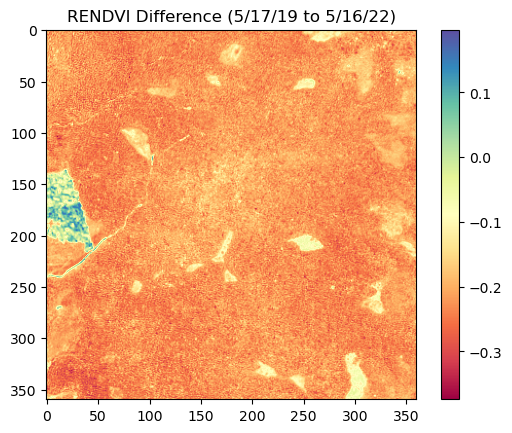

<Figure size 640x480 with 0 Axes>

In [24]:
# change detection = after - before
# blue is ndvi gain and red is ndvi loss

rendvi_diff = rendvi_zz - rendvi_w
plt.imshow(rendvi_diff, cmap='Spectral')
plt.title("RENDVI Difference (5/17/19 to 5/16/22)")
plt.colorbar()
plt.show()

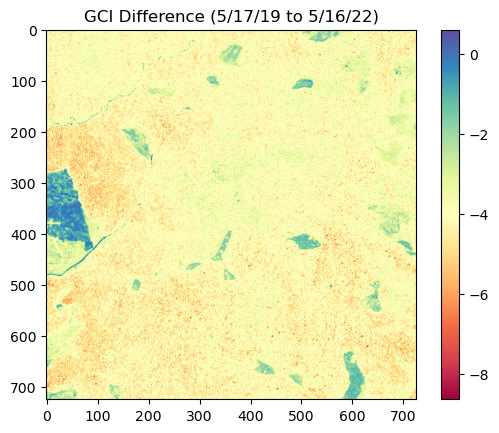

<Figure size 640x480 with 0 Axes>

In [25]:
# change detection = after - before
# blue is gci gain and red is gci loss

gci_diff = gci_zz - gci_w
plt.imshow(gci_diff, cmap='Spectral')
plt.colorbar()
plt.title('GCI Difference (5/17/19 to 5/16/22)')
plt.show()

In [26]:
tci19 = "tci1.tif"
tci19_ro = rasterio.open(tci19)
tci22 = "tci2.tif"
tci22_ro = rasterio.open(tci22)

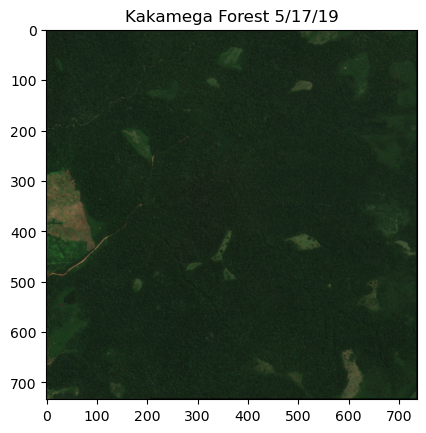

<Figure size 640x480 with 0 Axes>

In [27]:
# display true color image of first in time series (5/17/19)
red19, green19, blue19 = tci19_ro.read()
rgb19 = np.dstack((red19, green19, blue19))
plt.imshow(rgb19)
plt.title('Kakamega Forest 5/17/19')
plt.show()

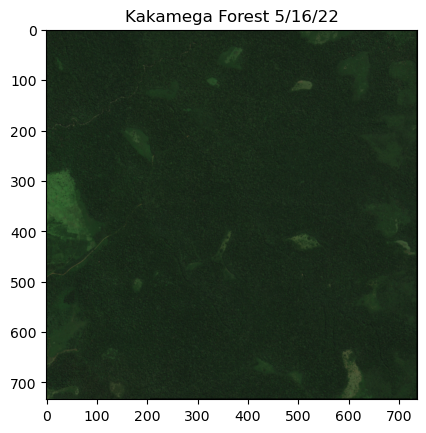

<Figure size 640x480 with 0 Axes>

In [28]:
# display true color image of last in time series (5/16/22)
red22, green22, blue22 = tci22_ro.read()
rgb22 = np.dstack((red22, green22, blue22))
plt.imshow(rgb22)
plt.title('Kakamega Forest 5/16/22')
plt.show()

In [29]:
print('\nMax NDVI 5/17/19: {m}'.format(m=ndvi_w.max()))
print('Mean NDVI 5/17/19: {m}'.format(m=ndvi_w.mean()))
print('Median NDVI 5/17/19: {m}'.format(m=np.median(ndvi_w)))
print('Min NDVI 5/17/19: {m}'.format(m=ndvi_w.min()))

print('\nMax NDVI 6/25/21: {m}'.format(m=ndvi_x.max()))
print('Mean NDVI 6/25/21: {m}'.format(m=ndvi_x.mean()))
print('Median NDVI 6/25/21: {m}'.format(m=np.median(ndvi_x)))
print('Min NDVI 6/25/21: {m}'.format(m=ndvi_x.min()))

print('\nMax NDVI 6/05/21: {m}'.format(m=ndvi_y.max()))
print('Mean NDVI 6/05/21: {m}'.format(m=ndvi_y.mean()))
print('Median NDVI 6/05/21: {m}'.format(m=np.median(ndvi_y)))
print('Min NDVI 6/05/21: {m}'.format(m=ndvi_y.min()))

print('\nMax NDVI 5/16/22: {m}'.format(m=ndvi_zz.max()))
print('Mean NDVI 5/16/22: {m}'.format(m=ndvi_zz.mean()))
print('Median NDVI 5/16/22: {m}'.format(m=np.median(ndvi_zz)))
print('Min NDVI 5/16/22: {m}'.format(m=ndvi_zz.min()))


Max NDVI 5/17/19: 0.9204216073781292
Mean NDVI 5/17/19: 0.8289316406495374
Median NDVI 5/17/19: 0.8384082001808864
Min NDVI 5/17/19: -0.02411665731912507

Max NDVI 6/25/21: 0.8989051945026788
Mean NDVI 6/25/21: 0.8178375507118503
Median NDVI 6/25/21: 0.8211559432933478
Min NDVI 6/25/21: 0.17125748502994012

Max NDVI 6/05/21: 0.9136189481017067
Mean NDVI 6/05/21: 0.8367710014287885
Median NDVI 6/05/21: 0.8431372549019608
Min NDVI 6/05/21: 0.014014014014014014

Max NDVI 5/16/22: 0.6441138606780146
Mean NDVI 5/16/22: 0.49028236395214864
Median NDVI 5/16/22: 0.4908762420957543
Min NDVI 5/16/22: 0.04909140222403038


In [30]:
print('\nMax NDMI 5/17/19: {m}'.format(m=ndmi_w.max()))
print('Mean NDMI 5/17/19: {m}'.format(m=ndmi_w.mean()))
print('Median NDMI 5/17/19: {m}'.format(m=np.median(ndmi_w)))
print('Min NDMI 5/17/19: {m}'.format(m=ndmi_w.min()))

print('\nMax NDMI 6/25/21: {m}'.format(m=ndmi_x.max()))
print('Mean NDM 6/25/21: {m}'.format(m=ndmi_x.mean()))
print('Median NDMI 6/25/21: {m}'.format(m=np.median(ndmi_x)))
print('Min NDMI 6/25/21: {m}'.format(m=ndmi_x.min()))

print('\nMax NDMI 6/05/21: {m}'.format(m=ndmi_y.max()))
print('Mean NDMI 6/05/21: {m}'.format(m=ndmi_y.mean()))
print('Median NDMI 6/05/21: {m}'.format(m=np.median(ndmi_y)))
print('Min NDMI 6/05/21: {m}'.format(m=ndmi_y.min()))

print('\nMax NDMI 5/16/22: {m}'.format(m=ndmi_zz.max()))
print('Mean NDMI 5/16/22: {m}'.format(m=ndmi_zz.mean()))
print('Median NDMI 5/16/22: {m}'.format(m=np.median(ndmi_zz)))
print('Min NDMI 5/16/22: {m}'.format(m=ndmi_zz.min()))


Max NDMI 5/17/19: 0.22851456486339786
Mean NDMI 5/17/19: -0.33316041412992736
Median NDMI 5/17/19: -0.34262027779870124
Min NDMI 5/17/19: -0.5089649551752241

Max NDMI 6/25/21: 0.11083743842364532
Mean NDM 6/25/21: -0.3467930274176848
Median NDMI 6/25/21: -0.3473205257836198
Min NDMI 6/25/21: -0.5217192501143119

Max NDMI 6/05/21: -0.041868555100012424
Mean NDMI 6/05/21: -0.3592626906173954
Median NDMI 6/05/21: -0.36105997504054177
Min NDMI 6/05/21: -0.5345957756737072

Max NDMI 5/16/22: -0.018240778273206325
Mean NDMI 5/16/22: -0.24143377269246796
Median NDMI 5/16/22: -0.24213912541828297
Min NDMI 5/16/22: -0.3817671092951992


In [31]:
print('\nMax RENDVI 5/17/19: {m}'.format(m=rendvi_w.max()))
print('Mean RENDVI 5/17/19: {m}'.format(m=rendvi_w.mean()))
print('Median RENDVI 5/17/19: {m}'.format(m=np.median(rendvi_w)))
print('Min RENDVI 5/17/19: {m}'.format(m=rendvi_w.min()))

print('\nMax RENDVI 6/25/21: {m}'.format(m=rendvi_x.max()))
print('Mean RENDVI 6/25/21: {m}'.format(m=rendvi_x.mean()))
print('Median RENDVI 6/25/21: {m}'.format(m=np.median(rendvi_x)))
print('Min RENDVI 6/25/21: {m}'.format(m=rendvi_x.min()))

print('\nMax RENDVI 6/05/21: {m}'.format(m=rendvi_y.max()))
print('Mean RENDVI 6/05/21: {m}'.format(m=rendvi_y.mean()))
print('Median RENDVI 6/05/21: {m}'.format(m=np.median(rendvi_y)))
print('Min RENDVI 6/05/21: {m}'.format(m=rendvi_y.min()))

print('\nMax RENDVI 5/16/22: {m}'.format(m=rendvi_zz.max()))
print('Mean RENDVI 5/16/22: {m}'.format(m=rendvi_zz.mean()))
print('Median RENDVI 5/16/22: {m}'.format(m=np.median(rendvi_zz)))
print('Min RENDVI 5/16/22: {m}'.format(m=rendvi_zz.min()))


Max RENDVI 5/17/19: 0.6460513796384396
Mean RENDVI 5/17/19: 0.5186087989038722
Median RENDVI 5/17/19: 0.5245683930942895
Min RENDVI 5/17/19: 0.08773087071240106

Max RENDVI 6/25/21: 0.6618075801749271
Mean RENDVI 6/25/21: 0.5138784816717592
Median RENDVI 6/25/21: 0.5163290615957007
Min RENDVI 6/25/21: 0.1172566371681416

Max RENDVI 6/05/21: 0.6616577799321377
Mean RENDVI 6/05/21: 0.5342274408100466
Median RENDVI 6/05/21: 0.5387780314756958
Min RENDVI 6/05/21: 0.06936696580160077

Max RENDVI 5/16/22: 0.41738851459736925
Mean RENDVI 5/16/22: 0.30501340233259777
Median RENDVI 5/16/22: 0.3046744574290484
Min RENDVI 5/16/22: 0.13043478260869565


In [33]:
print('\nMax GCI 5/17/19: {m}'.format(m=gci_w.max()))
print('Mean GCI 5/17/19: {m}'.format(m=gci_w.mean()))
print('Median GCI 5/17/19: {m}'.format(m=np.median(gci_w)))
print('Min GCI 5/17/19: {m}'.format(m=gci_w.min()))

print('\nMax GCI 6/25/21: {m}'.format(m=gci_x.max()))
print('Mean GCI 6/25/21: {m}'.format(m=gci_x.mean()))
print('Median GCI 6/25/21: {m}'.format(m=np.median(gci_x)))
print('Min GCI 6/25/21: {m}'.format(m=gci_x.min()))

print('\nMax GCI 6/05/21: {m}'.format(m=gci_y.max()))
print('Mean GCI 6/05/21: {m}'.format(m=gci_y.mean()))
print('Median GCI 6/05/21: {m}'.format(m=np.median(gci_y)))
print('Min GCI 6/05/21: {m}'.format(m=gci_y.min()))

print('\nMax GCI 5/16/22: {m}'.format(m=gci_zz.max()))
print('Mean GCI 5/16/22: {m}'.format(m=gci_zz.mean()))
print('Median GCI 5/16/22: {m}'.format(m=np.median(gci_zz)))
print('Min GCI 5/16/22: {m}'.format(m=gci_zz.min()))


Max GCI 5/17/19: 10.331103678929766
Mean GCI 5/17/19: 5.617598198383278
Median GCI 5/17/19: 5.667493796526054
Min GCI 5/17/19: 0.02473498233215543

Max GCI 6/25/21: 9.356435643564357
Mean GCI 6/25/21: 5.271806397916009
Median GCI 6/25/21: 5.2773722627737225
Min GCI 6/25/21: 0.573076923076923

Max GCI 6/05/21: 9.755555555555556
Mean GCI 6/05/21: 5.67431275893291
Median GCI 6/05/21: 5.721611721611722
Min GCI 6/05/21: 0.24675324675324672

Max GCI 5/16/22: 2.9389993145990405
Mean GCI 5/16/22: 1.6096427047210273
Median GCI 5/16/22: 1.599023709902371
Min GCI 5/16/22: 0.10767468499427268


In [50]:
# from: https://doc.arcgis.com/en/insights/latest/analyze/calculate-percent-change.htm
# (final_value-initial_value)/initial_value*100
ndvi_average_change = (ndvi_zz.mean() - ndvi_w.mean()) / ndvi_w.mean() * 100
print('\nNDVI Average Rate of Change from 5/17/19 to 5/16/22 was {m}%'.format(m=round(ndvi_average_change,2)))
ndmi_average_change = (ndmi_zz.mean() - ndmi_w.mean()) / ndmi_w.mean() * 100
print('NDMI Average Rate of Change from 5/17/19 to 5/16/22 was {m}%'.format(m=round(ndmi_average_change,2)))
rendvi_average_change = (rendvi_zz.mean() - rendvi_w.mean()) / rendvi_w.mean() * 100
print('RENDVI Average Rate of Change from 5/17/19 to 5/16/22 was {m}%'.format(m=round(rendvi_average_change,2)))
gci_average_change = (gci_zz.mean() - gci_w.mean()) / gci_w.mean() * 100
print('GCI Average Rate of Change from 5/17/19 to 5/16/22 was {m}%'.format(m=round(gci_average_change,2)))


NDVI Average Rate of Change from 5/17/19 to 5/16/22 was -40.85%
NDMI Average Rate of Change from 5/17/19 to 5/16/22 was -27.53%
RENDVI Average Rate of Change from 5/17/19 to 5/16/22 was -41.19%
GCI Average Rate of Change from 5/17/19 to 5/16/22 was -71.35%
